# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 22, 6, 37, 30, 731699)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
os.environ["HOPSWORKS_API_KEY"] = "hnoLoEhnnXr0NIlt.hIAb7iCp86nnF4QNTjpsgJrURRwFTMG80Pe0JrMQjwa31eQCnTEr0cVjtyb8K9Tn"

project = hopsworks.login(project="id2223_labs_24")
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1161371


Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [4]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=2,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=2,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.425612E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
air_quality_lagged_fg = fs.get_feature_group(
    name='air_quality_lagged',
    version=1,
)

In [8]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.72s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-24 00:00:00+00:00,3.90,0.0,15.463244,167.905258,stockholm
1,2024-11-23 00:00:00+00:00,-2.90,0.0,8.640000,270.000000,stockholm
2,2024-11-25 00:00:00+00:00,7.25,0.3,18.775301,184.398621,stockholm
3,2024-11-26 00:00:00+00:00,5.70,0.0,12.434340,202.109497,stockholm
4,2024-11-27 00:00:00+00:00,5.60,0.0,3.671294,281.309906,stockholm
5,2024-11-28 00:00:00+00:00,1.40,0.0,12.641076,340.016815,stockholm
6,2024-11-29 00:00:00+00:00,-0.15,0.0,7.289445,327.094757,stockholm
7,2024-11-30 00:00:00+00:00,-0.20,0.0,5.091168,224.999893,stockholm


In [9]:
lagged_data = air_quality_lagged_fg.read()
latest_lagged_row = lagged_data.sort_values(by='date', ascending=False).iloc[0] 

batch_data['pm25lag1'] = latest_lagged_row['pm25lag1']
batch_data['pm25lag2'] = latest_lagged_row['pm25lag2']
batch_data['pm25lag3'] = latest_lagged_row['pm25lag3']
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.19s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25lag1,pm25lag2,pm25lag3
0,2024-11-24 00:00:00+00:00,3.90,0.0,15.463244,167.905258,stockholm,19.0,19.0,17.0
1,2024-11-23 00:00:00+00:00,-2.90,0.0,8.640000,270.000000,stockholm,19.0,19.0,17.0
2,2024-11-25 00:00:00+00:00,7.25,0.3,18.775301,184.398621,stockholm,19.0,19.0,17.0
3,2024-11-26 00:00:00+00:00,5.70,0.0,12.434340,202.109497,stockholm,19.0,19.0,17.0
4,2024-11-27 00:00:00+00:00,5.60,0.0,3.671294,281.309906,stockholm,19.0,19.0,17.0
5,2024-11-28 00:00:00+00:00,1.40,0.0,12.641076,340.016815,stockholm,19.0,19.0,17.0
6,2024-11-29 00:00:00+00:00,-0.15,0.0,7.289445,327.094757,stockholm,19.0,19.0,17.0
7,2024-11-30 00:00:00+00:00,-0.20,0.0,5.091168,224.999893,stockholm,19.0,19.0,17.0


In [10]:
batch_data.columns

Index(['date', 'temperature_2m_mean', 'precipitation_sum',
       'wind_speed_10m_max', 'wind_direction_10m_dominant', 'city', 'pm25lag1',
       'pm25lag2', 'pm25lag3'],
      dtype='object')

In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         8 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          8 non-null      float32            
 2   precipitation_sum            8 non-null      float32            
 3   wind_speed_10m_max           8 non-null      float32            
 4   wind_direction_10m_dominant  8 non-null      float32            
 5   city                         8 non-null      object             
 6   pm25lag1                     8 non-null      float64            
 7   pm25lag2                     8 non-null      float64            
 8   pm25lag3                     8 non-null      float64            
dtypes: datetime64[us, UTC](1), float32(4), float64(3), object(1)
memory usage: 576.0+ bytes


In [12]:
# Retrieve model features
model_features = retrieved_xgboost_model.get_booster().feature_names

# Preprocess 'date' column
# Ensure the 'date' column is in UTC and convert to seconds since epoch
# batch_data['date'] = batch_data['date'].dt.tz_convert('UTC')  # Ensure it's in UTC
# batch_data['date'] = batch_data['date'].view('int64') // 10**9  # Convert to seconds since epoch


# Encode 'city' column
batch_data['city'] = batch_data['city'].astype('category').cat.codes

# Ensure the batch data has the features expected by the model
for i in range(len(batch_data)):
    # Select only model features in the correct order
    input_data = batch_data.loc[i, model_features].to_frame().T
    
    # Ensure all data is float for the model
    input_data = input_data.astype(float)
    
    # Predict pm25
    predicted_pm25 = retrieved_xgboost_model.predict(input_data)[0]
    batch_data.loc[i, 'predicted_pm25'] = predicted_pm25

    # Update lagged features
    if i + 1 < len(batch_data):
        batch_data.loc[i + 1, 'pm25lag1'] = predicted_pm25
        batch_data.loc[i + 1, 'pm25lag2'] = batch_data.loc[i, 'pm25lag1']
        batch_data.loc[i + 1, 'pm25lag3'] = batch_data.loc[i, 'pm25lag2']


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [13]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25lag1,pm25lag2,pm25lag3,predicted_pm25
0,2024-11-24 00:00:00+00:00,3.90,0.0,15.463244,167.905258,0,19.000000,19.000000,17.000000,29.553082
1,2024-11-23 00:00:00+00:00,-2.90,0.0,8.640000,270.000000,0,29.553082,19.000000,19.000000,33.965729
2,2024-11-25 00:00:00+00:00,7.25,0.3,18.775301,184.398621,0,33.965729,29.553082,19.000000,38.321487
3,2024-11-26 00:00:00+00:00,5.70,0.0,12.434340,202.109497,0,38.321487,33.965729,29.553082,29.181074
4,2024-11-27 00:00:00+00:00,5.60,0.0,3.671294,281.309906,0,29.181074,38.321487,33.965729,20.514997
5,2024-11-28 00:00:00+00:00,1.40,0.0,12.641076,340.016815,0,20.514997,29.181074,38.321487,21.247999
6,2024-11-29 00:00:00+00:00,-0.15,0.0,7.289445,327.094757,0,21.247999,20.514997,29.181074,34.721855
7,2024-11-30 00:00:00+00:00,-0.20,0.0,5.091168,224.999893,0,34.721855,21.247999,20.514997,34.948090


In [14]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         8 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          8 non-null      float32            
 2   precipitation_sum            8 non-null      float32            
 3   wind_speed_10m_max           8 non-null      float32            
 4   wind_direction_10m_dominant  8 non-null      float32            
 5   city                         8 non-null      int8               
 6   pm25lag1                     8 non-null      float64            
 7   pm25lag2                     8 non-null      float64            
 8   pm25lag3                     8 non-null      float64            
 9   predicted_pm25               8 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), float64(3), int

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [15]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25lag1,pm25lag2,pm25lag3,predicted_pm25,street,country,days_before_forecast_day
1,2024-11-23 00:00:00+00:00,-2.90,0.0,8.640000,270.000000,stockholm,29.553082,19.000000,19.000000,33.965729,st eriksgatan 83,sweden,2
0,2024-11-24 00:00:00+00:00,3.90,0.0,15.463244,167.905258,stockholm,19.000000,19.000000,17.000000,29.553082,st eriksgatan 83,sweden,1
2,2024-11-25 00:00:00+00:00,7.25,0.3,18.775301,184.398621,stockholm,33.965729,29.553082,19.000000,38.321487,st eriksgatan 83,sweden,3
3,2024-11-26 00:00:00+00:00,5.70,0.0,12.434340,202.109497,stockholm,38.321487,33.965729,29.553082,29.181074,st eriksgatan 83,sweden,4
4,2024-11-27 00:00:00+00:00,5.60,0.0,3.671294,281.309906,stockholm,29.181074,38.321487,33.965729,20.514997,st eriksgatan 83,sweden,5
5,2024-11-28 00:00:00+00:00,1.40,0.0,12.641076,340.016815,stockholm,20.514997,29.181074,38.321487,21.247999,st eriksgatan 83,sweden,6
6,2024-11-29 00:00:00+00:00,-0.15,0.0,7.289445,327.094757,stockholm,21.247999,20.514997,29.181074,34.721855,st eriksgatan 83,sweden,7
7,2024-11-30 00:00:00+00:00,-0.20,0.0,5.091168,224.999893,stockholm,34.721855,21.247999,20.514997,34.948090,st eriksgatan 83,sweden,8


In [16]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, 1 to 7
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         8 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          8 non-null      float32            
 2   precipitation_sum            8 non-null      float32            
 3   wind_speed_10m_max           8 non-null      float32            
 4   wind_direction_10m_dominant  8 non-null      float32            
 5   city                         8 non-null      object             
 6   pm25lag1                     8 non-null      float64            
 7   pm25lag2                     8 non-null      float64            
 8   pm25lag3                     8 non-null      float64            
 9   predicted_pm25               8 non-null      float32            
 10  street                       8 non-null      object        

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2024-11-22 06:37:40,533 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



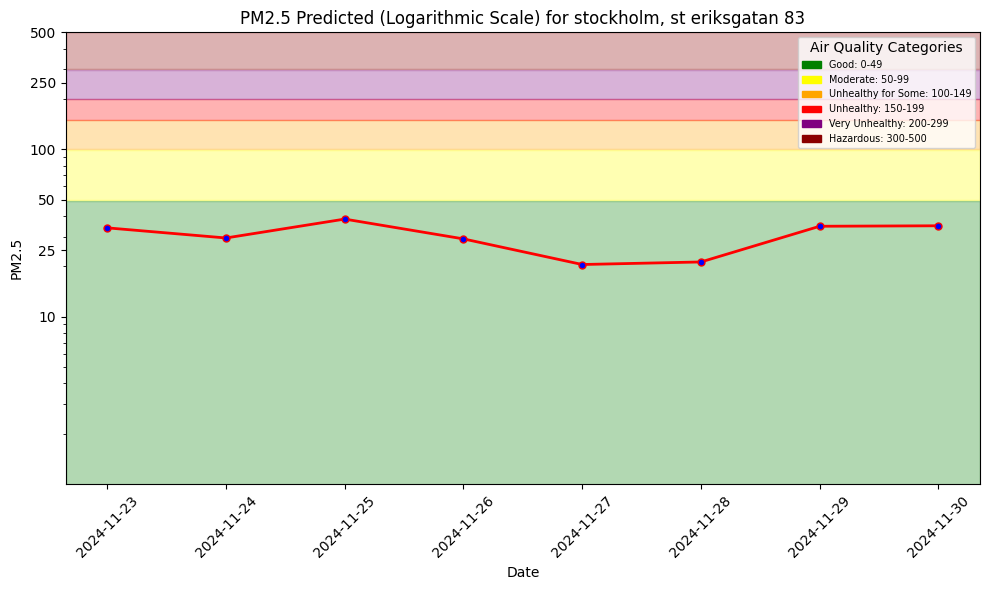

In [17]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [18]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [19]:
batch_data = batch_data.drop(columns=['pm25lag1', 'pm25lag2', 'pm25lag3'])


In [20]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/8 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization


Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1161371/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7fbe9ca6d5a0>, None)

In [21]:
monitor_fg.read().sort_values('date')

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.92s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
9,2024-11-17 00:00:00+00:00,6.45,0.0,18.388212,246.948669,stockholm,23.755095,st eriksgatan 83,sweden,1
1,2024-11-18 00:00:00+00:00,2.50,0.0,10.895576,277.594543,stockholm,33.488567,st eriksgatan 83,sweden,3
5,2024-11-19 00:00:00+00:00,0.80,0.0,2.620839,105.945465,stockholm,37.041576,st eriksgatan 83,sweden,4
10,2024-11-19 00:00:00+00:00,1.25,0.0,3.617955,95.710503,stockholm,32.618816,st eriksgatan 83,sweden,3
22,2024-11-20 00:00:00+00:00,1.25,0.1,24.087738,350.537750,stockholm,24.363827,st eriksgatan 83,sweden,7
6,2024-11-20 00:00:00+00:00,1.25,0.4,25.932495,13.650437,stockholm,17.029465,st eriksgatan 83,sweden,9
15,2024-11-20 00:00:00+00:00,1.20,0.2,24.640940,11.802421,stockholm,10.786509,st eriksgatan 83,sweden,8
8,2024-11-21 00:00:00+00:00,-2.90,0.3,26.727423,297.255249,stockholm,17.825569,st eriksgatan 83,sweden,1
4,2024-11-22 00:00:00+00:00,-5.35,0.0,15.124284,268.636108,stockholm,20.185211,st eriksgatan 83,sweden,2
33,2024-11-22 00:00:00+00:00,-5.30,0.0,15.840000,270.000000,stockholm,20.773211,st eriksgatan 83,sweden,1


In [22]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.62s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-21 00:00:00+00:00,-2.90,0.3,26.727423,297.255249,stockholm,17.825569,st eriksgatan 83,sweden,1
1,2024-11-17 00:00:00+00:00,6.45,0.0,18.388212,246.948669,stockholm,23.755095,st eriksgatan 83,sweden,1
2,2024-11-22 00:00:00+00:00,-5.30,0.0,15.840000,270.000000,stockholm,20.773211,st eriksgatan 83,sweden,1
3,2024-11-24 00:00:00+00:00,3.90,0.0,15.463244,167.905258,stockholm,29.553082,st eriksgatan 83,sweden,1


In [23]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.93s) 


,date,pm25,country,city,street,url
0,2022-03-14 00:00:00+00:00,76.0,sweden,stockholm,st eriksgatan 83,https://api.waqi.info/feed/@10523
1,2021-03-14 00:00:00+00:00,42.0,sweden,stockholm,st eriksgatan 83,https://api.waqi.info/feed/@10523
2,2020-01-06 00:00:00+00:00,12.0,sweden,stockholm,st eriksgatan 83,https://api.waqi.info/feed/@10523
3,2021-03-07 00:00:00+00:00,19.0,sweden,stockholm,st eriksgatan 83,https://api.waqi.info/feed/@10523
4,2020-05-30 00:00:00+00:00,11.0,sweden,stockholm,st eriksgatan 83,https://api.waqi.info/feed/@10523
...,...,...,...,...,...,...
2181,2024-11-18 00:00:00+00:00,17.0,sweden,stockholm,st eriksgatan 83,https://api.waqi.info/feed/@10523
2182,2024-11-19 00:00:00+00:00,19.0,sweden,stockholm,st eriksgatan 83,https://api.waqi.info/feed/@10523
2183,2024-11-20 00:00:00+00:00,19.0,sweden,stockholm,st eriksgatan 83,https://api.waqi.info/feed/@10523
2184,2024-11-21 00:00:00+00:00,19.0,sweden,stockholm,st eriksgatan 83,https://api.waqi.info/feed/@10523


In [24]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
    
hindcast_df

,date,predicted_pm25,pm25
1,2024-11-17 00:00:00+00:00,23.755095,15.0
0,2024-11-21 00:00:00+00:00,17.825569,19.0
2,2024-11-22 00:00:00+00:00,20.773211,7.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

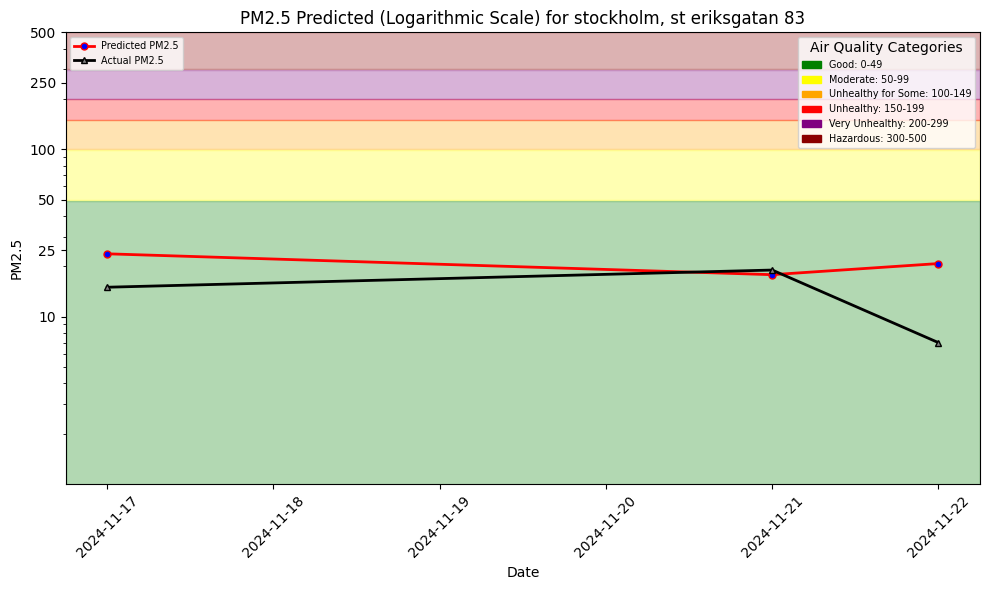

In [25]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---